In [37]:
import numpy as np
import scipy.constants as const
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd

In [38]:
# Constants
h = const.h        # Planck constant in J·s
c = const.c        # Speed of light in m/s
k_B = const.k      # Boltzmann constant in J/K

In [39]:
# Planck function in W·m^-2·Hz^-1·sr^-1
def planck_nu(nu, T):
    return (2 * h * nu**3) / (c**2) / (np.exp(h * nu / (k_B * T)) - 1)

In [40]:
# Read data from CSV file
# Ensure your CSV file has the columns: Frequency_cm_inv, Residual_kJy_per_sr, Uncertainty_kJy_per_sr
data = pd.read_csv('monopole_spectrum.csv')


freq_cm_inv = data['Frequency (cm^-1)'].values       # in cm^-1
residuals_kJy_per_sr = data['Residual (kJy/sr)'].values   # in kJy/sr
uncertainties_kJy_per_sr = data['Uncertainty (1 sigma)'].values

# Convert frequencies from cm^-1 to Hz
c_cm_per_s = c * 100  # Convert c from m/s to cm/s
freq_Hz = freq_cm_inv * c_cm_per_s  # in Hz

# Convert residuals and uncertainties to W·m^-2·Hz^-1·sr^-1
# 1 kJy = 1e3 Jy = 1e3 * 1e-26 W·m^-2·Hz^-1·sr^-1 = 1e-23 W·m^-2·Hz^-1·sr^-1
residuals_W_m2_Hz_sr = residuals_kJy_per_sr * 1e-23
uncertainties_W_m2_Hz_sr = uncertainties_kJy_per_sr * 1e-23

In [ ]:
# Reference temperature T0 (used in initial model)
T0 = 2.6  # K

# Compute initial blackbody spectrum B_nu(T0)
B_nu_T0 = planck_nu(freq_Hz, T0)

# Compute measured intensity I_nu^measured = B_nu(T0) + R_nu
I_nu_measured = B_nu_T0 + residuals_W_m2_Hz_sr

# The uncertainties in measured intensity are the same as in the residuals
I_nu_uncertainties = uncertainties_W_m2_Hz_sr


In [ ]:
# Define the fit function (Planck function)
def fit_function(nu, T):
    return planck_nu(nu, T)


# Initial guess for temperature
T_initial_guess = 2.7  # K

# Perform the non-linear least squares fit
popt, pcov = curve_fit(
    fit_function, freq_Hz, I_nu_measured,
    p0=[T_initial_guess],
    sigma=I_nu_uncertainties,
    absolute_sigma=True,
    method='trf' # Trust Region Reflective algorithm (robust for non-linear problems)
)

In [43]:
# Extract the best-fit temperature and its uncertainty
T_best = popt[0]
sigma_T = np.sqrt(np.diag(pcov))[0]

print(f"Best-fit temperature: {T_best:.5f} K")
print(f"Uncertainty in temperature: ±{sigma_T:.5f} K")

Best-fit temperature: 2.60000 K
Uncertainty in temperature: ±0.00001 K


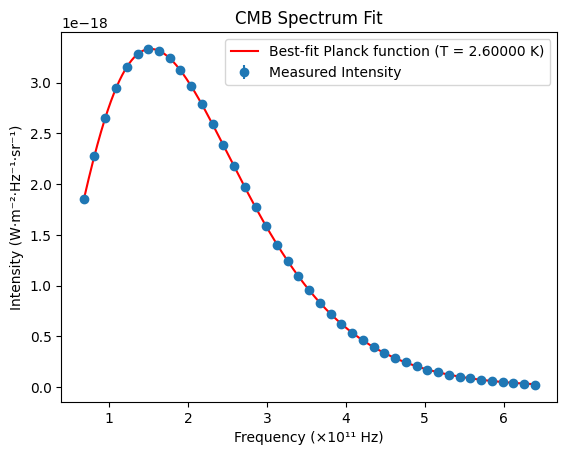

In [44]:
# Plot the data and the fit
plt.errorbar(freq_Hz / 1e11, I_nu_measured, yerr=I_nu_uncertainties,
             fmt='o', label='Measured Intensity')
freq_Hz_fit = np.linspace(freq_Hz.min(), freq_Hz.max(), 1000)
I_nu_fit = planck_nu(freq_Hz_fit, T_best)
plt.plot(freq_Hz_fit / 1e11, I_nu_fit, 'r-',
         label=f'Best-fit Planck function (T = {T_best:.5f} K)')
plt.xlabel('Frequency (×10¹¹ Hz)')
plt.ylabel('Intensity (W·m⁻²·Hz⁻¹·sr⁻¹)')
plt.title('CMB Spectrum Fit')
plt.legend()
plt.savefig('cmb_fit.png')
plt.show()